# 데이콘 소득 예측 경진대회 EDA

- 예측이지만, binary classification 문제
- 간단한 EDA와 변수 가공
- NA처리와 패턴 분석을 주로 수행.

# 변수 설명

```
id : 샘플 아이디
age : 나이
workclass : 일 유형 (범주)
fnlwgt : CPS(Current Population Survey) 가중치 (이 사람이 표본에 뽑힐 가능성에 따른 가중치. 높을수록 뽑히기 어려운 사람?)
education : 교육수준 (범주)
education.num : 교육수준 번호 (범주)
marital.status : 결혼 상태 (범주)
occupation : 직업 (범주)
relationship : 가족관계 (범주)
race : 인종 (범주)
sex : 성별 (범주)
capital.gain : 자본 이익 (부동산, 토지, 주식 등)
capital.loss : 자본 손실
hours.per.week : 주당 근무시간
native.country : 본 국적 (범주)
target : 소득 (target)
					   0 = <=50K (5만 달러 이하)

					   1 = >50K (5만 달러 초과) 
```


- 이를 통해 생각한 가설들.
    - 'education'과 'education.num' 둘 중 하나만 사용면되는 dummi 변수로 생각된다.
    - 'workclass'와 'occupation'이 둘다 비어있는 경우, 백수로 취급하고 level을 추가해도 된다.(workclass na, occupation na 둘다인 경우)
    - sample submit 결과, target의 불균형이 크다. stratified kfold와 oversampling 사용을 고려한다.
    - 나이도 더미변수로 활용해 보는 것이 좋아보인다. (범주화 또는 변수 추가)
    - 본 국적을, 해외 노동자 여부 (0,1 로 바꾸는건 어떨까? 그대로 쓰면, curse of dimmension 일 듯하다.)
    - marital.status와 성별이 있다면, relation-ship이 필요할지. (다중 공선성 문제)




In [10]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import sys

In [11]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

In [12]:
#분석 관련
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from statsmodels.formula.api import ols

# 데이터 확인

In [13]:
# 파일 불러오기
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
#submission = pd.read_csv('./data/sample_submission.csv')

In [14]:
#컬럼명 변경
# . 이 있으면 분석시 오류가 생겨서.
train.columns = train.columns.str.replace('.','_')
test.columns = test.columns.str.replace('.','_')

C:\Users\USER\AppData\Local\Temp/ipykernel_13692/760497911.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train.columns = train.columns.str.replace('.','_')
C:\Users\USER\AppData\Local\Temp/ipykernel_13692/760497911.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test.columns = test.columns.str.replace('.','_')


In [15]:
train

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


In [16]:
test

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,47,Private,304133,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
1,1,34,Self-emp-inc,154227,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,75,United-States
2,2,31,Local-gov,158291,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,8614,0,40,United-States
3,3,28,Private,183155,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
4,4,54,Local-gov,182543,Some-college,10,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,30,Local-gov,182926,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,40,United-States
15077,15077,39,Private,176101,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
15078,15078,48,Private,242406,11th,7,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,Puerto-Rico
15079,15079,44,Private,100584,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States


In [17]:
# 데이터 차원 확인하기
print('train : ',train.shape)
print("test : ", test.shape)

train :  (17480, 16)
test :  (15081, 15)


## 타입 체크


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              17480 non-null  int64 
 1   age             17480 non-null  int64 
 2   workclass       15644 non-null  object
 3   fnlwgt          17480 non-null  int64 
 4   education       17480 non-null  object
 5   education_num   17480 non-null  int64 
 6   marital_status  17480 non-null  object
 7   occupation      15637 non-null  object
 8   relationship    17480 non-null  object
 9   race            17480 non-null  object
 10  sex             17480 non-null  object
 11  capital_gain    17480 non-null  int64 
 12  capital_loss    17480 non-null  int64 
 13  hours_per_week  17480 non-null  int64 
 14  native_country  16897 non-null  object
 15  target          17480 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.1+ MB


- 3컬럼 정도가 na가 있음을 알 수있다.
- 그리고 가설에서 예상했던 것처럼, workclass가 na면 ocupation도 na일 가능성이 높아보인다. (백수예상)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education_num   15081 non-null  int64 
 6   marital_status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital_gain    15081 non-null  int64 
 12  capital_loss    15081 non-null  int64 
 13  hours_per_week  15081 non-null  int64 
 14  native_country  15081 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.7+ MB


In [20]:
np.sum(test.isna())

id                0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

test set에는 na는 없다.

# 범주형 level 확인

In [21]:
print('educatuon \n',train['education'].unique())
print('educatuon.num \n',train['education_num'].unique())

print('workclass \n',train['workclass'].unique())

print('marital.status \n',train['marital_status'].unique())

print('occupation \n',train['occupation'].unique())

print('relationship \n',train['relationship'].unique())

print('race \n',train['race'].unique())

print('sex \n',train['sex'].unique())

print('native.country \n',train['native_country'].unique())

educatuon 
 ['Assoc-acdm' 'Some-college' 'Bachelors' 'HS-grad' 'Prof-school' '10th'
 '11th' 'Masters' '7th-8th' '1st-4th' 'Assoc-voc' '5th-6th' 'Doctorate'
 '9th' '12th' 'Preschool']
educatuon.num 
 [12 10 13  9 15  6  7 14  4  2 11  3 16  5  8  1]
workclass 
 ['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay' nan 'Never-worked']
marital.status 
 ['Married-civ-spouse' 'Never-married' 'Divorced' 'Separated'
 'Married-AF-spouse' 'Married-spouse-absent' 'Widowed']
occupation 
 ['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces' nan]
relationship 
 ['Husband' 'Own-child' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race 
 ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex 
 ['Male' 'Female']
native.country 
 ['United-States' 'Poland' 

같은 범주인데도, 오타가 없는지 확인해본다.

## NA 체크

- dacon sample 함수 사용

In [22]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: workclass 입니다
해당 컬럼에 총 1836 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: occupation 입니다
해당 컬럼에 총 1843 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: native_country 입니다
해당 컬럼에 총 583 개의 결측치가 존재합니다.


결측치가 있는 row들을 확인.

In [23]:
# 결측치가 있는 row들을 확인합니다.
train[train.isna().sum(axis=1) > 0]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
15081,15081,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
15082,15082,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
15083,15083,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,1
15084,15084,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,1
15085,15085,22,Private,119592,Assoc-acdm,12,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,2824,40,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


보다시피, NA값이 너무 많아서 가설에 따라 데이터를 채워 주려고한다.

# 범주형 데이터

## workclass & occupation

workclass 와 occupation의 na값을 위주로 분석

가설확인을 위해 workclass와 occupation 둘다 na인 행 출력

In [24]:
type1= train['workclass'].isna()
type2= train['occupation'].isna()

two_na=train[type1&type2]
two_na

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
15081,15081,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
15082,15082,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
15084,15084,51,NaN,172175,Doctorate,16,Never-married,NaN,Not-in-family,White,Male,0,2824,40,United-States,1
15086,15086,61,NaN,135285,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,2603,32,United-States,0
15087,15087,71,NaN,100820,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,2489,15,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


예상과 다르게, 결혼도 안했고 workclass&occupation이 na인데도( two_na ) 고소득층이 존재.

이런 경우가 진짜 NA값이라 생각해서 제거해주거나 패턴을 확인.

더 자세히 분석하기위해, two_na데이터를 target에 따라 feature 별 시각화.

In [25]:
two_na_cate = two_na.drop(['id','workclass','occupation', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'],axis = 1) #범주형이 아닌 피쳐 drop
two_na_cate.head()

,education,marital_status,relationship,race,sex,native_country,target
15081,HS-grad,Widowed,Not-in-family,White,Female,United-States,0
15082,Some-college,Widowed,Unmarried,Black,Female,United-States,0
15084,Doctorate,Never-married,Not-in-family,White,Male,United-States,1
15086,HS-grad,Married-civ-spouse,Husband,White,Male,United-States,0
15087,HS-grad,Married-civ-spouse,Husband,White,Male,United-States,0


In [26]:
print('workclass & occupation 이 na지만, 고소득층인 경우',len(two_na_cate[two_na_cate['target']==1]) )

workclass & occupation 이 na지만, 고소득층인 경우 191


191건 정도는 날려도 된다고 생각하지만, capital gain이 높을 수도 있어서, 확인해본다.

<AxesSubplot:title={'center':'capital gain and marriage'}, xlabel='marital_status', ylabel='capital_gain'>

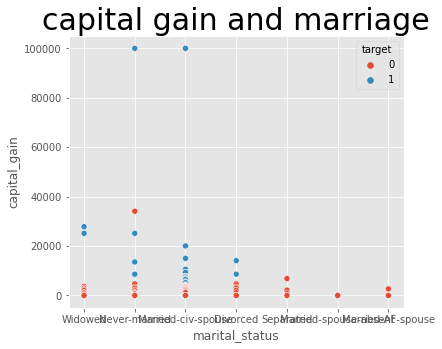

In [27]:
two_na_cate = two_na.drop(['id','workclass','occupation', 'age', 'fnlwgt', 'education_num', 'hours_per_week'],axis = 1) #범주형이 아닌 피쳐 drop

plt.figure(figsize=(6, 5))
plt.title('capital gain and marriage', fontsize = 30)
sns.scatterplot(x = 'marital_status',y= 'capital_gain', hue= 'target', data= two_na_cate)

two_na 고소득자(target==1) 중에서, gain을 확인해본 결과,

married를 제외하고, capital gain이 50k 이하인 것은 제거하는 것이 옳다고 보인다.(직업이 있음에도, 직업을 알 수 없는 경우이다.)

마지막으로, 어떤 work class에 할당할지 분석,

<AxesSubplot:title={'center':'education and age'}, xlabel='education', ylabel='capital_gain'>

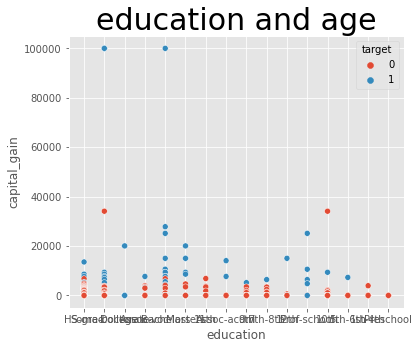

In [28]:

plt.figure(figsize=(6, 5))
plt.title('education and age', fontsize = 30)
sns.scatterplot(x = 'education',y= 'capital_gain', hue= 'target', data= two_na_cate)


<AxesSubplot:title={'center':'education and capital_gain'}, xlabel='education', ylabel='capital_gain'>

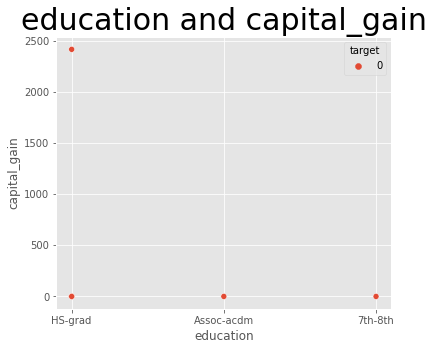

In [29]:

plt.figure(figsize=(6, 5))
plt.title('education and capital_gain', fontsize = 30)
sns.scatterplot(x = 'education',y= 'capital_gain', hue= 'target', data= train[train['workclass']=='Without-pay'])

<AxesSubplot:title={'center':'education and capital_gain'}, xlabel='education', ylabel='capital_gain'>

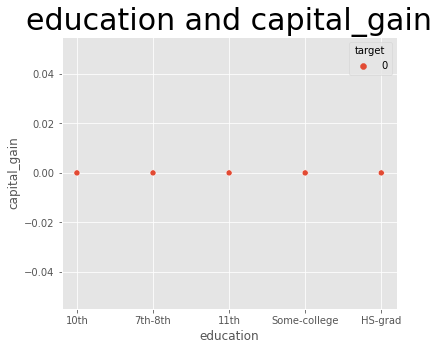

In [30]:
plt.figure(figsize=(6, 5))
plt.title('education and capital_gain', fontsize = 30)
sns.scatterplot(x = 'education',y= 'capital_gain', hue= 'target', data= train[train['workclass']=='Never-worked'])

never-worked와 withoutpay 모두 그렸지만, 일치해보이는 workclass가 없어서 새로할당.

workclass <- no-working, occupation <- baeksu

## 본 국적 확인 (native.country )

본 국적에 na값이 많아서 다 제거하고 싶으나, 카이제곱 검정을 통해 나라에 따라 영향이 있는지 검정하려고함.

또한, 미국 vs 그외로 분류 해볼 생각.

In [31]:
print('native country na 수 :',len(train[train['native_country'].isna()] ))

native country na 수 : 583


In [32]:
native_country_table=train['native_country'].value_counts()
native_country_table

United-States                 15393
Mexico                          355
Philippines                     108
Germany                          75
Canada                           63
Puerto-Rico                      59
El-Salvador                      58
Cuba                             49
India                            47
England                          46
Jamaica                          42
China                            40
South                            39
Italy                            38
Dominican-Republic               38
Columbia                         37
Guatemala                        36
Poland                           35
Japan                            33
Vietnam                          32
Taiwan                           28
Haiti                            23
Nicaragua                        20
Portugal                         20
Ecuador                          19
Ireland                          18
Iran                             17
Peru                        

### 단변량 그림

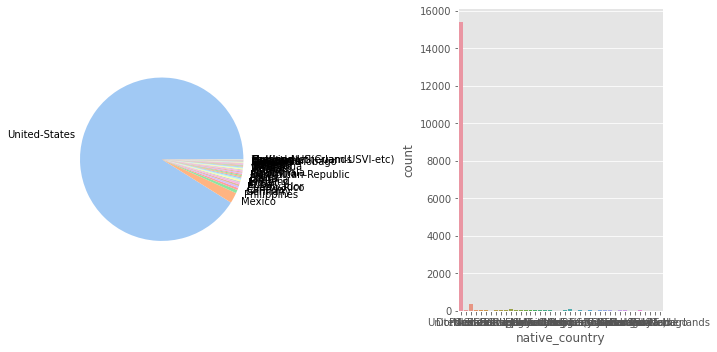

In [33]:
colors = sns.color_palette('pastel')[0:42]
#create pie chart
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.pie(train['native_country'].value_counts(),labels=native_country_table.index,colors=colors)
plt.subplot(1,2,2)
sns.countplot(data=train, x="native_country")


#sns.countplot(data=train, x="native.country")
plt.tight_layout()
plt.show()

미국,멕시코 순으로 빈도가 많다. 그 외의 국가는 매우 희소하다.

### 이변량 그림

target vs 본 국적

In [34]:
country_crosstab=pd.crosstab(train['native_country'],train['target'])
country_crossgtab_res=chi2_contingency(country_crosstab)

In [35]:
print('Chi2 Statistic: {}, p-value: {}'.format(country_crossgtab_res[0], country_crossgtab_res[1]))
print('기각')

Chi2 Statistic: 198.0845348336186, p-value: 8.189153114434088e-23
기각


독립성 검정결과 국적에 따라, 차이가 있음을 검정을 통해서 확인 할 수 있다.

하지만, 국적별로 도수가 크게 다르기 때문에 검정 결과를 신뢰할 수는 없어서 분포를 본다.

<AxesSubplot:xlabel='native_country'>

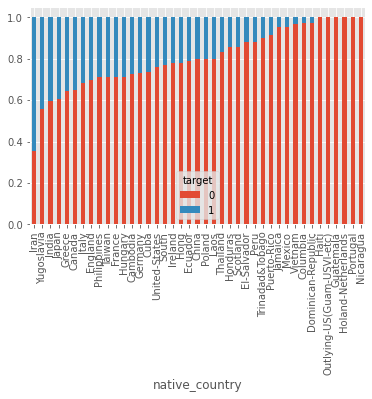

In [36]:
#ratio plot 제작
def ratio_table(cross_tab):
    return cross_tab.div(cross_tab.sum(axis=1),axis='index')

country_ratio=ratio_table(country_crosstab)
country_ratio=country_ratio.sort_values(by=0)

country_ratio.plot(kind='bar',stacked=True)

국가마다 각각 다른 분포를 띄고있음을 볼 수 있다.

기울기에따라

그룹핑을 0.5 이상 , 0.5~ 0.3, 0.3 ~0.1 , 그 외

이렇게 분류도 가능하다.

In [37]:
prob_dict=dict(country_ratio[1])

In [38]:
group1=[]
group2=[]
group3=[]
group4=[]

for country in train['native_country'].unique():
    country_data=train[train['native_country']==country]['target']
    probs=sum(country_data)/country_data.count()
    if probs >=0.5:
        group1.append(country)
    elif probs < 0.5 and probs >=0.3:
        group2.append(country)
    elif probs < 0.3 and probs >=0.1:
        group3.append(country)
    else:
        group4.append(country)
    #print(country,probs)

C:\Users\USER\AppData\Local\Temp/ipykernel_13692/3800910895.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  probs=sum(country_data)/country_data.count()


In [39]:
print('group1 :',group1)
print()
print('group2 :',group2)
print()
print('group3 :',group3)
print()
print('group4 :',group4)

group1 : ['Iran']

group2 : ['Greece', 'Canada', 'India', 'Italy', 'England', 'Yugoslavia', 'Japan']

group3 : ['United-States', 'Poland', 'Ireland', 'El-Salvador', 'Philippines', 'South', 'Cuba', 'Laos', 'Hong', 'Germany', 'Ecuador', 'France', 'Taiwan', 'China', 'Honduras', 'Peru', 'Hungary', 'Cambodia', 'Trinadad&Tobago', 'Thailand', 'Scotland']

group4 : ['Mexico', 'Guatemala', 'Dominican-Republic', 'Portugal', 'Jamaica', 'Columbia', 'Vietnam', 'Haiti', 'Puerto-Rico', 'Outlying-US(Guam-USVI-etc)', 'Nicaragua', 'Holand-Netherlands', nan]


분류결과, 어느정도 개발도상국과 아닌국가로 나눠진듯 하다.

물론 도수가 적어서 outlier도 존재한다.

또는 1~3 그룹을 묶어도 될까?

그룹이 잘 나눠졌는지 검정

In [40]:
train_sample = train.copy()
train_sample['native_country']=train_sample['native_country'].replace(group1,0)
train_sample['native_country']=train_sample['native_country'].replace(group2,1)
train_sample['native_country']=train_sample['native_country'].replace(group3,2)
train_sample['native_country']=train_sample['native_country'].replace(group4,3)

In [41]:
country_crosstab=pd.crosstab(train_sample['native_country'],train['target'])
country_crosstab_res=chi2_contingency(country_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(country_crosstab_res[0], country_crosstab_res[1]))
print('기각')

Chi2 Statistic: 105.44049038326594, p-value: 1.0504950307344402e-22
기각


In [42]:
country_crosstab

target,0,1
native_country,,
0.0,6,11
1.0,161,89
2.0,12126,3834
3.0,1081,172


이란이 outlier로 그냥 1그룹에 포함시켜도 될것같다.

### 그외 변수들

#### education

In [43]:
education_crosstab=pd.crosstab(train['education'],train['target'])
education_crosstab_res=chi2_contingency(education_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(education_crosstab_res[0], education_crosstab_res[1]))
print('기각')

Chi2 Statistic: 2443.5943646339265, p-value: 0.0
기각


<AxesSubplot:xlabel='education'>

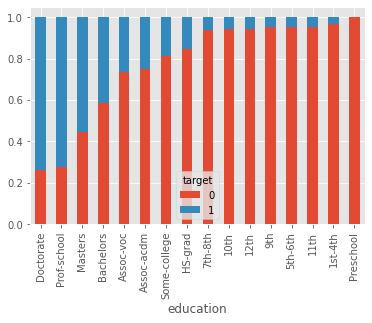

In [44]:
education_ratio=ratio_table(education_crosstab)
education_ratio=education_ratio.sort_values(by=0)

education_ratio.plot(kind='bar',stacked=True)


(doc, prof), (master~ 고졸) (그 이하)로 그룹을 나눠도 될것같아 보인다.


<AxesSubplot:xlabel='education_num'>

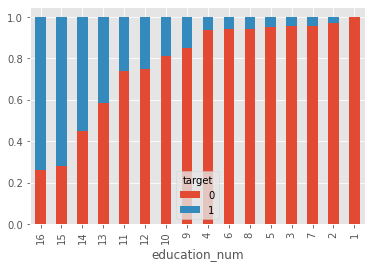

In [45]:
education_crosstab=pd.crosstab(train['education_num'],train['target'])
education_ratio=ratio_table(education_crosstab)
education_ratio=education_ratio.sort_values(by=0)

education_ratio.plot(kind='bar',stacked=True)

자세히보면 education num이 순위형 데이터임을 볼 수 있다.

In [46]:
edu_group1=[16,15]
edu_group2=[15,14,13,11,12,10,9]
edu_group3=[4,6,8,5,3,7,2,1]

#### sex 변수

In [47]:
sex_crosstab=pd.crosstab(train['sex'],train['target'])
sex_crosstab_res=chi2_contingency(sex_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(sex_crosstab_res[0],sex_crosstab_res[1]))
print('기각')

Chi2 Statistic: 803.6657285997125, p-value: 8.611285797911765e-177
기각


<AxesSubplot:xlabel='sex'>

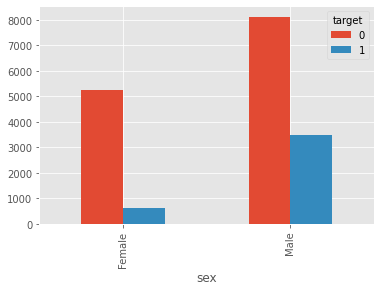

In [48]:
sex_crosstab.plot(kind='bar')

성별에 따라 영향이 있음을 알 수 있다.

#### relation 변수

In [49]:
relation_crosstab=pd.crosstab(train['relationship'],train['target'])
relation_crosstab_res=chi2_contingency(relation_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(relation_crosstab_res[0],relation_crosstab_res[1]))
print('relationship 기각')

Chi2 Statistic: 3490.993872583679, p-value: 0.0
relationship 기각


<AxesSubplot:xlabel='relationship'>

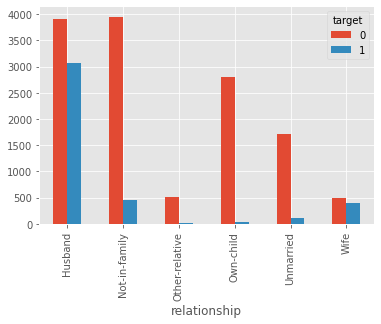

In [50]:
relation_crosstab.plot(kind='bar')

relationship에 따라, 달라짐을 볼 수 있다.

#### marital 변수

In [51]:
marital_crosstab=pd.crosstab(train['marital_status'],train['target'])
marital_crosstab_res=chi2_contingency(marital_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(marital_crosstab_res[0],marital_crosstab_res[1]))
print('결혼관계 기각')



Chi2 Statistic: 3410.448216124024, p-value: 0.0
결혼관계 기각


<AxesSubplot:xlabel='marital_status'>

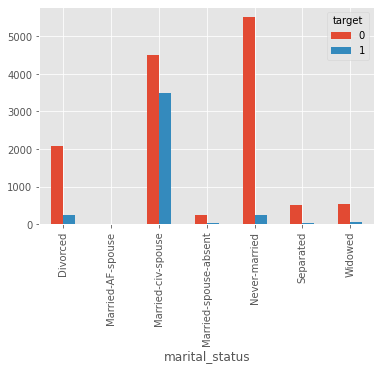

In [52]:
marital_crosstab.plot(kind='bar')

### 다중공선성 확인

relationship, sex, marital status 다중공선성 확인

https://mindscale.kr/course/basic-stat-python/13/


In [53]:

model = ols("target ~ {}+ {} + {}".format("marital_status","relationship","sex"), train)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     371.6
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:34:41   Log-Likelihood:                -7814.8
No. Observations:               17480   AIC:                         1.566e+04
Df Residuals:                   17467   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.2641      0.035      7.467      0.000       0.195       0.333
marital_status[T.Married-AF-spouse]         0.0828      0.106      0.783      0.434      -0.124       0.290
marital_status[T.Married-civ-spouse]        0.1299      0.034      3.793      0.000       0.063       0.197
marital_status[T.Married-spouse-absent]    -0.0302      0.025     -1.189      0.235      -0.080       0.020
marital_status[T.Never-married]            -0.0490      0.010     -4.815      0.000      -0.069      -0.029
marital_status[T.Separated]                -0.0368      0.018     -2.031      0.042      -0.072      -0.001
marital_status[T.Widowed]                  -0.0169      0.018     -0.963      0.336      -0.051       0.018
relationship[T.Not-in-family]              -0.1534      0.034     -4.500      0.000      -0.220      -0.087
relationship[T.Other-relative]             -0.2340      0.034     -6.947      0.000      -0.300      -0.168
relationship[T.Own-child]                  -0.2344      0.034     -6.948      0.000      -0.301      -0.168
relationship[T.Unmarried]                  -0.1952      0.035     -5.516      0.000      -0.265      -0.126
relationship[T.Wife]                        0.0554      0.016      3.544      0.000       0.025       0.086
sex[T.Male]                                 0.0467      0.008      5.797      0.000       0.031       0.062
==============================================================================
Omnibus:                     1457.786   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1610.109
Skew:                           0.707   Prob(JB):                         0.00
Kurtosis:                       2.541   Cond. No.                         53.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,marital_status[T.Married-AF-spouse],1.090550
1,marital_status[T.Married-civ-spouse],35.501610
2,marital_status[T.Married-spouse-absent],1.094387
3,marital_status[T.Never-married],2.796655
4,marital_status[T.Separated],1.198917
5,marital_status[T.Widowed],1.227092
6,relationship[T.Not-in-family],26.765038
7,relationship[T.Other-relative],4.090521
8,relationship[T.Own-child],18.869597
9,relationship[T.Unmarried],14.267796


공선성이 성별보다는, 결혼 관계와 relationship에서 발생함을 볼 수 있다.

In [55]:
model = ols("target ~ {}+ {}".format("marital_status","sex"), train)
res = model.fit()
#res.summary()

In [56]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,marital_status[T.Married-AF-spouse],1.005244
1,marital_status[T.Married-civ-spouse],2.731938
2,marital_status[T.Married-spouse-absent],1.092457
3,marital_status[T.Never-married],2.364690
4,marital_status[T.Separated],1.195188
5,marital_status[T.Widowed],1.222216
6,sex[T.Male],1.255760


결혼관계와 성별만 활용시 공선성이 떨어짐을 볼 수 있다.

relationship은 제거 후 사용하자.

absent와 widowed는 유의하지않는걸 볼 수 있다. (어떤 조치가 필요할까..)

# 수치형 데이터 분포 확인

### age

<AxesSubplot:xlabel='age', ylabel='Count'>

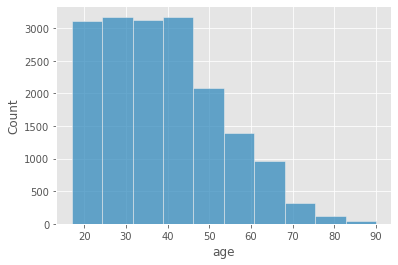

In [57]:
sns.histplot(train['age'],bins=10)

나이 데이터는 좌로 편향됨을 볼 수 있다.

변환이나 더미데이터화가 필요하다.

<AxesSubplot:xlabel='age', ylabel='Count'>

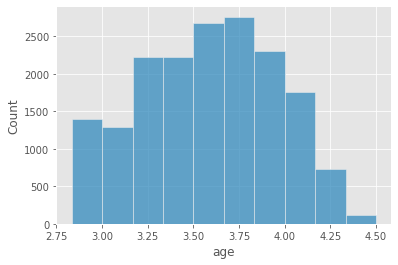

In [58]:
sns.histplot(np.log(train['age']),bins=10)


log 변환시 완화됨을 볼 수 있다.

### age 이변량

<AxesSubplot:xlabel='age', ylabel='Count'>

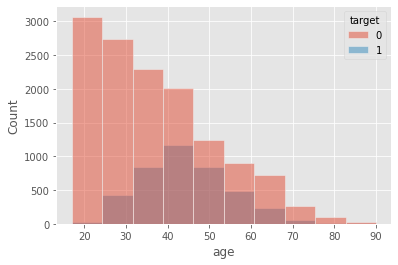

In [59]:
sns.histplot(x='age',hue='target',bins=10,data=train)

30~50 사이에 가장 많음을 볼 수 있다.

<AxesSubplot:xlabel='age', ylabel='Count'>

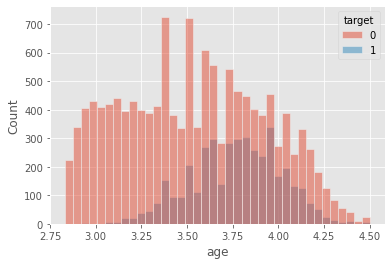

In [60]:
sns.histplot(x=np.log(train['age']),hue=train['target'])

In [61]:
print(np.exp(3.25))
print(np.exp(4.1))

25.790339917193062
60.34028759736195


26세에서 60세 기준으로 더미변수를 생성해주자.

그리고 log변환한 데이터를 사용

### capital.gain

<AxesSubplot:xlabel='capital_gain', ylabel='Count'>

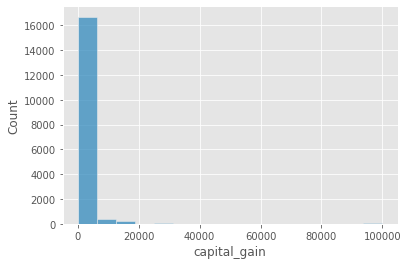

In [62]:
sns.histplot(train['capital_gain'])

<AxesSubplot:xlabel='capital_gain', ylabel='Count'>

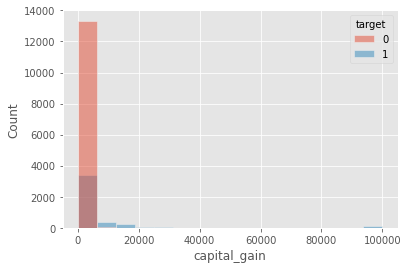

In [63]:
sns.histplot(x='capital_gain',hue='target',data=train)

어느 정도 수준 이상이면, 상당히 유의해짐을 볼 수 있다.

In [64]:
kstest(train['capital_gain'], train['target'])


KstestResult(statistic=0.1523455377574371, pvalue=1.4104971987882321e-177)

검정 결과도 유의하다

### capital.loss

<AxesSubplot:xlabel='capital_loss', ylabel='Count'>

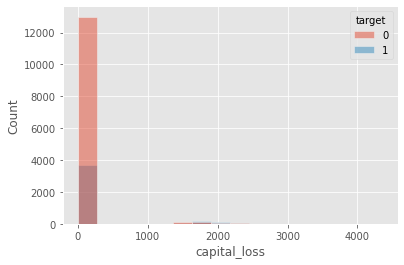

In [65]:
sns.histplot(x='capital_loss',hue='target',data=train)

In [66]:
kstest(train['capital_loss'], train['target'])
#loss도 마찬가지로 유의하다

KstestResult(statistic=0.19021739130434778, pvalue=2.092585207225024e-277)

# 변수 가공

앞에서 찾은 인사이트들로, 변수 가공을 수행


In [67]:
train

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


In [68]:
#NA 처리

#국가 na 처리
train_modified=train[train['native_country'].isna()!=True].copy()
test_modified=test[test['native_country'].isna()!=True].copy()

In [69]:
#workclass & occupation na 처리

type1= train_modified['workclass'].isna()
type2= train_modified['occupation'].isna()

type3= train_modified['capital_gain']<50000
type4=train_modified['target']==1

train_modified.loc[type1&type2,'workclass']=train_modified.loc[type1&type2,'workclass'].replace(np.nan,'no-working')
train_modified.loc[type1&type2,'occupation']=train_modified.loc[type1&type2,'occupation'].replace(np.nan,'baeksu')
train_modified.drop(train_modified[type1&type2&type3&type4].index , axis=0,inplace=True)
# two_na 지만, 소득이 상위권중 capital_gain도 낮은 경우는 제거.


train_modified=train_modified.dropna()#남은 na제거

In [70]:
#education grouping


edu_group1=[16,15]
edu_group2=[15,14,13,11,12,10,9]
edu_group3=[4,6,8,5,3,7,2,1]

train_modified['education1']=0
train_modified['education2']=0
train_modified['education3']=0

test_modified['education1']=0
test_modified['education2']=0
test_modified['education3']=0


train_modified.loc[train_modified['education_num'].isin(edu_group1),'education1'] = 1
train_modified.loc[train_modified['education_num'].isin(edu_group2),'education2'] = 1
train_modified.loc[train_modified['education_num'].isin(edu_group3),'education3'] = 1

#education num 자체는 순위형 데이터라 삭제안함.
test_modified.loc[test_modified['education_num'].isin(edu_group1),'education1'] = 1
test_modified.loc[test_modified['education_num'].isin(edu_group2),'education2'] = 1
test_modified.loc[test_modified['education_num'].isin(edu_group3),'education3'] = 1


In [71]:
#education 제거
train_modified.drop('education',axis=1,inplace=True)
test_modified.drop('education',axis=1,inplace=True)

#relationship drop
train_modified.drop('relationship',axis=1,inplace=True)
test_modified.drop('relationship',axis=1,inplace=True)

In [72]:
#국가 grouping
country_group1=[]
country_group2=[]
country_group3=[]
country_group4=[]

for country in train_modified['native_country'].unique():
    country_data=train_modified[train_modified['native_country']==country]['target']
    probs=sum(country_data)/country_data.count()
    if probs >=0.5:
        country_group1.append(country)
    elif probs < 0.5 and probs >=0.3:
        country_group2.append(country)
    elif probs < 0.3 and probs >=0.1:
        country_group3.append(country)
    else:
        country_group4.append(country)
    #print(country,probs)

print(country_group1)
print(country_group2)
print(country_group3)
print(country_group4)

train_modified['country_group1']=0
train_modified['country_group2']=0
train_modified['country_group3']=0
train_modified['country_group4']=0


test_modified['country_group1']=0
test_modified['country_group2']=0
test_modified['country_group3']=0
test_modified['country_group4']=0


train_modified.loc[train_modified['native_country'].isin(country_group1),'country_group1'] = 1
train_modified.loc[train_modified['native_country'].isin(country_group2),'country_group2'] = 1
train_modified.loc[train_modified['native_country'].isin(country_group3),'country_group3'] = 1
train_modified.loc[train_modified['native_country'].isin(country_group4),'country_group4'] = 1

test_modified.loc[test_modified['native_country'].isin(country_group1),'country_group1'] = 1
test_modified.loc[test_modified['native_country'].isin(country_group2),'country_group2'] = 1
test_modified.loc[test_modified['native_country'].isin(country_group3),'country_group3'] = 1
test_modified.loc[test_modified['native_country'].isin(country_group4),'country_group4'] = 1

train_modified.drop('native_country',axis=1,inplace=True)
test_modified.drop('native_country',axis=1,inplace=True)


['Iran']
['Greece', 'Canada', 'India', 'England', 'Yugoslavia', 'Japan']
['United-States', 'Poland', 'Ireland', 'El-Salvador', 'Philippines', 'Italy', 'South', 'Cuba', 'Laos', 'Hong', 'Germany', 'Ecuador', 'France', 'Taiwan', 'China', 'Honduras', 'Peru', 'Hungary', 'Cambodia', 'Trinadad&Tobago', 'Thailand']
['Mexico', 'Guatemala', 'Dominican-Republic', 'Portugal', 'Jamaica', 'Columbia', 'Vietnam', 'Haiti', 'Puerto-Rico', 'Outlying-US(Guam-USVI-etc)', 'Nicaragua', 'Scotland', 'Holand-Netherlands']


In [73]:
#age 가공
train_modified['age']=np.log(train_modified['age'])# log로 
train_modified['age_group']=0

test_modified['age']=np.log(test_modified['age'])# log로 
test_modified['age_group']=0



train_modified.loc[(train_modified['age']>3.25)& (train_modified['age']<4.1),'age_group']=1
test_modified.loc[(test_modified['age']>3.25)& (test_modified['age']<4.1),'age_group']=1




In [74]:
#catboost용 더미변수를 더 생성하지않고, 출력.
train_modified.drop('id',axis=1,inplace=True)
test_modified.drop('id',axis=1,inplace=True)


train_modified.to_csv('./data/train_cat_modified.csv',index=False)
test_modified.to_csv('./data/test_cat_modified.csv',index=False)



In [75]:
#나머지 더미변수 만들기

train_modified=pd.concat([train_modified,pd.get_dummies(train_modified['marital_status'], drop_first=True)],axis=1)
train_modified=pd.concat([train_modified,pd.get_dummies(train_modified['race'], drop_first=True)],axis=1)
train_modified=pd.concat([train_modified,pd.get_dummies(train_modified['workclass'], drop_first=True)],axis=1)
train_modified=pd.concat([train_modified,pd.get_dummies(train_modified['occupation'], drop_first=True)],axis=1)
train_modified=pd.concat([train_modified,pd.get_dummies(train_modified['sex'], drop_first=True)],axis=1)

test_modified=pd.concat([test_modified,pd.get_dummies(test_modified['marital_status'], drop_first=True)],axis=1)
test_modified=pd.concat([test_modified,pd.get_dummies(test_modified['race'], drop_first=True)],axis=1)
test_modified=pd.concat([test_modified,pd.get_dummies(test_modified['workclass'], drop_first=True)],axis=1)
test_modified=pd.concat([test_modified,pd.get_dummies(test_modified['occupation'], drop_first=True)],axis=1)
test_modified=pd.concat([test_modified,pd.get_dummies(test_modified['sex'], drop_first=True)],axis=1)

test_modified['no-working']=0
test_modified['baeksu']=0



train_modified.drop(['marital_status','race','workclass','occupation','sex'],axis=1,inplace=True)
test_modified.drop(['marital_status','race','workclass','occupation','sex'],axis=1,inplace=True)



In [77]:
train_modified.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,target,education1,education2,education3,...,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,baeksu,Male
0,3.465736,309513,12,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,3.496508,205469,10,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3.828641,149949,10,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3.135494,193090,13,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.007333,60193,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
test_modified.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,education1,education2,education3,country_group1,...,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Male,no-working,baeksu
0,3.850148,304133,10,0,0,45,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3.526361,154227,10,0,0,75,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3.433987,158291,13,8614,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3.332205,183155,13,0,0,55,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,3.988984,182543,10,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
train_modified.to_csv("./data/train_modified_dummy.csv",index=False)
test_modified.to_csv("./data/test_modified_dummy.csv",index=False)

# 결론


1. workclass &  occupation이 둘다 na인 경우, 상황에따라 제거하거나 workclass : no-working, occupation : baeksu 라는 level을 만들어 삽입해주었다.
2. education과 education.num은 education.num만 남겼다. 그리고 grouping 해줘서 가변수를 생성.
3. 나이 데이터는특정 나이대에 따라 소득 여부가 확실히 보이기 때문에 가변수를 추가해줬다.
4. 국적데이터는 na는 모두 제거하고, grouping 해줬다.
5. 다중공선성 고려하여, relationship 컬럼 제거.

문제점. workclass : no-working, occupation : baeksu는 trainset에만 존재하는 level이 되서, 오히려 학습에 방해되지않을까.